In [ ]:
cd ./CNN_design_for_AD/

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import os

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
from numpy.random import permutation
import yaml

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Config

In [5]:
config_name = 'config.yaml'
with open(os.path.join('./'+config_name), 'r') as f:
    cfg = yaml.load(f)

# Load Data

In [6]:
from datasets.adni_3d import ADNI_3D
from models.build_model import build_model

In [106]:
dir_to_scans = 'dir/to/ADNI_processed/subjects'
dir_to_tsv = './datasets/files'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)   

In [56]:
category = ['CN','MCI','AD']

In [101]:
def visualize_example(Test_dataset,sub_id):
    plt.figure(figsize=(10, 10))
    image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[26,:,:]),cmap = 'gray')
    plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]] , fontsize=10)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,57,:]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,50]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)

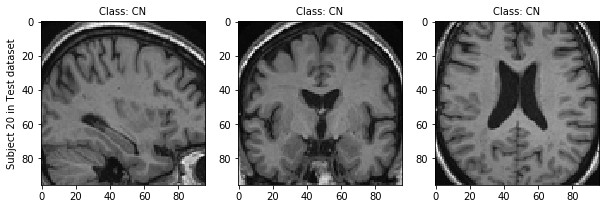

In [102]:
visualize_example(Test_dataset,20)

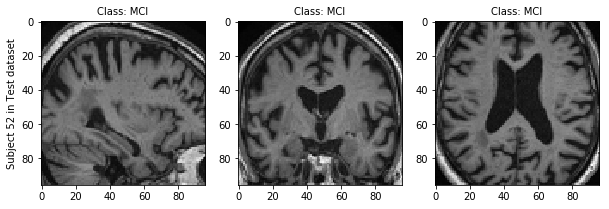

In [103]:
visualize_example(Test_dataset,52)

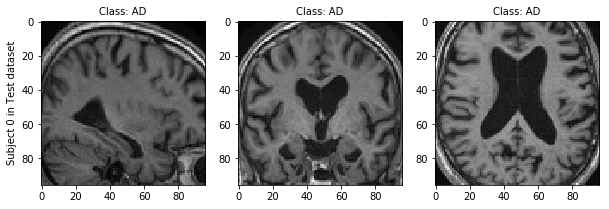

In [104]:
visualize_example(Test_dataset,0)

# Utility functions

In [8]:
from sklearn.metrics import confusion_matrix
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [9]:
def calc_aucs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc

In [10]:
def plot_rocs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc[k+1] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc[k+2] = auc(fpr["macro"], tpr["macro"])
    plotting_fpr = []
    plotting_tpr = []
    for k in range(cfg['model']['n_label']):
        plotting_fpr.append(fpr[k])
        plotting_tpr.append(tpr[k])
    plotting_fpr += [fpr["micro"], fpr["macro"]]
    plotting_tpr += [tpr["micro"], tpr["macro"]]
    auc_outs = [plotting_fpr, plotting_tpr, roc_auc]
    name = ['CN vs all ','MCI vs all ', 'AD vs all ', 'Micro ', 'Macro ']             
    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
    plt.figure()
    for i, color in zip(range(len(auc_outs[0])), colors):
        plt.plot(auc_outs[0][i], auc_outs[1][i], color=color, lw=2, label=name[i] + 'ROC curve (area = %0.2f)' % auc_outs[2][i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curves')
    plt.legend(loc="lower right")

# Functions for model evaluations

In [11]:
def run_epoch(model,val_loader,use_age=False):
    logit_all = []
    target_all = []
    mmse_all = []
    patient_idx_all = []
    cdr_all = []
    for i, (input, target, patient_idx, mmse, cdr_sub, age_id) in enumerate(val_loader):
        if i % 20 == 0:
            print('Iteration: ',i)
        input = input.to(device)
        target = target.to(device)
        if use_age:
            age_id = age_id.to(device)
        else:
            age_id = None
        logit = model(input,age_id)
        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        mmse_all.append(mmse.cpu())
        patient_idx_all.append(patient_idx.cpu())
        cdr_all.append(cdr_sub.cpu())
    
    logit_all_catted = torch.cat(logit_all)
    target_all_catted = torch.cat(target_all)
    mmse_all_catted = torch.cat(mmse_all)
    patient_idx_all_catted = torch.cat(patient_idx_all)
    cdr_all_catted = torch.cat(cdr_all)
    return logit_all_catted.numpy(), target_all_catted.numpy(), mmse_all_catted.numpy(), patient_idx_all_catted.numpy(), cdr_all_catted.numpy() 

In [18]:
def evaluation_models(model_name,data_loader, expansion_list = [1],  num_trails = 10,percentage = 0.8, use_age = False, norm_type= 'Instance'):
    
    all_acc = np.zeros((len(expansion_list),num_trails))
    all_balanced_acc = np.zeros((len(expansion_list),num_trails))
    all_auc = []
    for i,ep in enumerate(expansion_list):
        cfg['model']['expansion'] = ep
        cfg['model']['norm_type'] = norm_type
        model = build_model(cfg)
        best_model_dir = './saved_model/'
        pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cpu')['state_dict']
        old_ks = list(pretrained_dict.keys()).copy()
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:]in model_dict.keys())}
        model_dict.update(pretrained_dict) 
        model.load_state_dict(model_dict)
        model = model.to(device)
        model = model.eval()
        logit_all,target_all,_,_,_= run_epoch(model, data_loader, use_age)
        #print(F.softmax(torch.tensor(logit_all[0:20]),dim=1))
        tes_auc = []
        for tes in range(num_trails):
            rand_idex = permutation(range(len(target_all)))[:int(percentage*len(target_all))]
            target_test = target_all[rand_idex]
            pred_test = np.argmax(logit_all,1)[rand_idex]
            logit_test = logit_all[rand_idex]
            all_acc[i,tes] =accuracy_score(target_test, pred_test)
            all_balanced_acc[i,tes] =balanced_accuracy_score(target_test, pred_test)
            tes_auc.append(calc_aucs(target_test,logit_test))
        plot_rocs(target_test,logit_test)
        all_auc.append(tes_auc)
        print(old_ks)
        print(list(pretrained_dict.keys()))
    return all_acc, all_balanced_acc, all_auc

In [22]:
def test_model(all_acc, all_balanced_acc,all_auc):
    for w_k in range(len(all_acc)):
        print('Mean Acc ', np.mean(all_acc[w_k]),'\t')
        print('STD Acc ', np.std(all_acc[w_k]),'\t')
        print('Mean Balanced Acc ', np.mean(all_balanced_acc[w_k]),'\t')
        print('std Balanced Acc ', np.std(all_balanced_acc[w_k]),'\t')
        avg_micro = []
        avg_macro = []
        for d in all_auc[w_k]:
            avg_micro.append( d['micro'])
            avg_macro.append( d['macro'])
        print('Micro mean: ',np.mean(avg_micro))
        print('Micro std: ', np.std(avg_micro))
        print('Macro mean: ',np.mean(avg_macro))
        print('Macro std: ',np.std(avg_macro))

# Load model

In [30]:
model = build_model(cfg)
model_file_name = 'age_expansion_8'

Iteration:  0
Iteration:  20
Iteration:  40
Iteration:  60
Iteration:  80
Iteration:  100
Iteration:  120
Iteration:  140
Iteration:  160
Iteration:  180
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.w

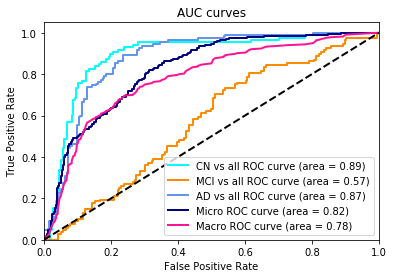

In [29]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')

In [31]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.68125 	
STD Acc  0.007565789473684216 	
Mean Balanced Acc  0.6965590032569433 	
std Balanced Acc  0.007475431973422053 	
Micro mean:  0.8242625735803324
Micro std:  0.004859012158648881
Macro mean:  0.7856490801930776
Macro std:  0.005688730409962248
